In [1]:
# Nikhil Patil
# CSEC 620 Project 4
# NLP and SMS Spam 

# Imports 
import pandas as pd
import numpy as np
import re, warnings, nltk, random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
sms = pd.read_csv('SMSSpamCollection', sep="\t", names=['label', 'text'])
print("\n\n",sms.head(), end='\n\n')
print(sms.info(), end='\n\n')
print(sms.describe(), end='\n\n')
print("The number of ham (non-spam) messages present are:",sms['label'].value_counts()[0])
print("The number of spam messages present are:",sms['label'].value_counts()[1])



   label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

       label                    text
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

The number of ham (non-spam) messages present are: 4825
The number of spam messages present are: 747


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nikhil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nikhil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nikhil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def tokenize(text):
    '''
    Simple text tokenizer that is used with the Term Frequency Inverse Document Frequency Vectorizer.\n 
    The way this function works is that it takes stop words from the Natural Language Toolkit NTLK[https://www.nltk.org/] 
    Passes them into a regex and uses WordNetLemmatizer to tokenize the text.
    :param text: to be tokenized
    :return: text tokens
    '''    
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()

    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    tokens = word_tokenize(text)

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

In [4]:
all_words = TfidfVectorizer(tokenizer=tokenize)

In [5]:
spam_word_counts = all_words.fit_transform(sms.loc[sms['label']=='spam']['text'].values);

spam_words = all_words.vocabulary_

spam_words_df = pd.DataFrame.from_dict(spam_words, orient='index')
spam_words_df.reset_index(inplace=True)
spam_words_df.columns = ['word', 'counts']

spam_words_df.sort_values(by='counts', ascending=False, inplace=True)
spam_words_df.head(15)

ham_word_counts = all_words.fit_transform(sms.loc[sms['label']=='ham']['text'].values)

ham_words = all_words.vocabulary_

ham_words_df = pd.DataFrame.from_dict(ham_words, orient='index')
ham_words_df.reset_index(inplace=True)
ham_words_df.columns = ['word', 'counts']

ham_words_df.sort_values(by='counts', ascending=False, inplace=True)
ham_words_df.head(15)

,word,counts
3875,zyada,6352
5265,zoom,6351
3902,zogtorius,6350
2341,zoe,6349
3881,zindgi,6348
3456,zhong,6347
6117,zero,6346
5636,zealand,6345
2147,zaher,6344
5099,zac,6343


In [6]:
tfidf = TfidfTransformer(smooth_idf=False)

spam_word_weights = tfidf.fit_transform(spam_word_counts)
top_idf_indices = tfidf.idf_.argsort()[:-5:-1]
ind_to_word = all_words.get_feature_names_out()
print('The most significant words for spam messages are:')
for ind in top_idf_indices:
    print(tfidf.idf_[ind], ind_to_word[ind])
    
ham_word_weights = tfidf.fit_transform(ham_word_counts)
top_idf_indices = tfidf.idf_.argsort()[:-5:-1]
ind_to_word = all_words.get_feature_names_out()
print('The most significant words for ham messages are:')
for ind in top_idf_indices:
    print(tfidf.idf_[ind], ind_to_word[ind])

The most significant words for spam messages are:
7.616065185132817 horse
7.616065185132817 horrible
7.616065185132817 howard
7.616065185132817 housing
The most significant words for ham messages are:
9.481566013773087 000pes
9.481566013773087 1405
9.481566013773087 15pm
9.481566013773087 16


In [7]:
class KMeans:
    """
    A simple K-means clustering implementation.

    This class implements the K-means clustering algorithm to group data points into `k` clusters
    based on their distance to the cluster centroids. The centroids are initialized randomly, and
    the algorithm iterates to minimize the within-cluster variance.

    Attributes:
        k (int): The number of clusters to form.
        max_iters (int): The maximum number of iterations for the algorithm to converge. Default is 100.
        centroids (np.ndarray): The coordinates of the cluster centroids.
        clusters (np.ndarray): The cluster labels for each data point.
    
    Methods:
        euclidean_distance(point1, point2): Computes the Euclidean distance between two data points.
        fit(X): Fits the K-means model to the data by determining the cluster centroids and assigning data points to clusters.
        predict(X): Predicts the nearest cluster for a new set of data points based on the fitted centroids.
        create_clusters(X): Assigns data points to the nearest cluster based on the current centroids.
        calculate_centroids(X): Calculates the new centroids based on the data points in each cluster.
    """

    def __init__(self, k=2, max_iters=100):
        self.k = k
        self.max_iters = max_iters
        self.centroids = None
        self.clusters = None

    def euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def fit(self, X):

        np.random.seed(88) 
        random_indices = np.random.permutation(X.shape[0])[:self.k]
        self.centroids = X[random_indices]

        for i in range(self.max_iters):
            self.clusters = self.create_clusters(X)
            old_centroids = self.centroids
            self.centroids = self.calculate_centroids(X)
            if np.all(old_centroids == self.centroids):
                break

    def create_clusters(self, X):
        clusters = [[] for _ in range(self.k)]
        for idx, point in enumerate(X):
            closest_centroid = np.argmin([self.euclidean_distance(point, centroid) for centroid in self.centroids])
            clusters[closest_centroid].append(idx)
        return clusters

    def calculate_centroids(self, X):
        centroids = np.zeros((self.k, X.shape[1]))
        for cluster_idx, cluster in enumerate(self.clusters):
            if cluster:  # Avoid empty clusters
                centroids[cluster_idx] = np.mean(X[cluster], axis=0)
        return centroids

    def predict(self, X):
        return np.array([np.argmin([self.euclidean_distance(x, centroid) for centroid in self.centroids]) for x in X])

In [8]:
class KNearestNeighbors:
    '''
    K-Nearest Neighbors Implementation

    Parameters: 
    k (int) : Number of components 

    Methods:
    fit(X, y): Fit the model using X as training data and y as target values
    predict(X): Predict the class labels for the provided data
    _predict(x): Predict the class label for a single data point

    '''
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)
    
    def _predict(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [9]:
# data preprocessing 

word_counts = all_words.fit_transform(sms['text'].values)

sms['label'] = sms['label'].map({'spam': 1, 'ham': 0})
y = sms['label'].values

tfidf_weights = tfidf.fit_transform(word_counts)

X = tfidf_weights.toarray()

In [12]:
# K Nearest Neighbors 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random.randint(1,100))

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_test_encoded = label_encoder.fit_transform(y_test)


knn = KNearestNeighbors(k=3)
knn.fit(X_train, y_encoded)

predictions = knn.predict(X_test)

accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"KNN Model Accuracy:{accuracy * 100:.2f}%")

print("Classification Report for K-Nearest Neighbors (KNN):")
print(classification_report(y_test_encoded, predictions, target_names=['ham', 'spam']))

conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Ham', 'Actual Spam'], columns=['Predicted Ham', 'Predicted Spam'])
print("Confusion Matrix:")
print(conf_matrix_df)

KNN Model Accuracy:66.82%
Classification Report for K-Nearest Neighbors (KNN):
              precision    recall  f1-score   support

         ham       0.86      0.74      0.79       966
        spam       0.11      0.20      0.14       149

    accuracy                           0.67      1115
   macro avg       0.48      0.47      0.47      1115
weighted avg       0.76      0.67      0.71      1115

Confusion Matrix:
             Predicted Ham  Predicted Spam
Actual Ham             715             251
Actual Spam            119              30


K-means Clustering Accuracy: 94.51%
Classification Report for K-Means:
              precision    recall  f1-score   support

         ham       0.95      0.99      0.97      4825
        spam       0.88      0.68      0.77       747

    accuracy                           0.95      5572
   macro avg       0.92      0.83      0.87      5572
weighted avg       0.94      0.95      0.94      5572



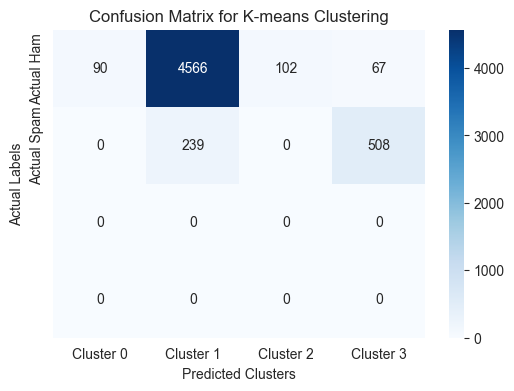

In [11]:
# K-means 
k = 4
kmeans = KMeans(k=k)
kmeans.fit(X)

predicted_clusters = kmeans.predict(X)

cluster_to_label = {}

for cluster in range(k):
    cluster_indices = np.where(predicted_clusters == cluster)[0]
    
    if len(cluster_indices) > 0: 
        most_common_label = np.bincount(y[cluster_indices]).argmax()
        cluster_to_label[cluster] = most_common_label

mapped_predictions = np.array([cluster_to_label[cluster] for cluster in predicted_clusters])
accuracy = accuracy_score(y, mapped_predictions)
print(f"K-means Clustering Accuracy: {accuracy * 100:.2f}%")
print("Classification Report for K-Means:")
print(classification_report(y, mapped_predictions, target_names=['ham', 'spam']))
conf_matrix = confusion_matrix(y, predicted_clusters)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3'], yticklabels=['Actual Ham', 'Actual Spam'])
plt.xlabel("Predicted Clusters")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix for K-means Clustering")
plt.show()